# Data visualization part 2

Below we'll cover a few more advanced packages for data visualization. First, we'll show how to plot a network using networkx. Then we'll show how to add interactivity to your plot with bokeh.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import stats
import seaborn as sns
import networkx as nx

### Colormap challenge
What type of colormap should we use for the following heatmap? Check [here](https://matplotlib.org/tutorials/colors/colormaps.html) for more colormaps.

In [2]:
rand_adj = np.random.randint(low=-5,high=5,size=(5,5))   #1
# rand_adj = np.random.randint(low=4, high=20, size=(5,5))   #2
# rand_adj = np.random.rand(5,5)    #3
# rand_adj = np.random.randint(low=0, high = 3, size=(5,5))    #4

print(rand_adj)

[[ 3 -3 -5  1  2]
 [-2 -3  4  2 -5]
 [ 1 -4 -2 -2 -3]
 [-4  2 -2 -4  4]
 [ 4  3 -2  3 -1]]


In [ ]:
# Some example colormaps
diverging = "BrBG"
sequential = "Blues"
qualitative = "Set2"

sns.heatmap(rand_adj, cbar_kws={'label': 'Streamline count'}, cmap=qualitative)

## Understanding the brain

The brain is, of course, extremely complicated. One way we try to understand how it might work is through studying connectivity patterns. The brain is anotomically partitioned into numerous regions, in the same way that the US is split up into 50 states. To understand how computations happen, we record the physical wiring between brain regions. This is akin to recording highways and other traffic routes between US states. So if we have two regions, say a visual region and a motor (movement) region, we can infer that they might communicate frequently if they have a strong wired connection running between them.

Below we will use data available (here)[https://complexsystemsupenn.com/codedata]. You can also download the data on Canvas (the data.zip folder).

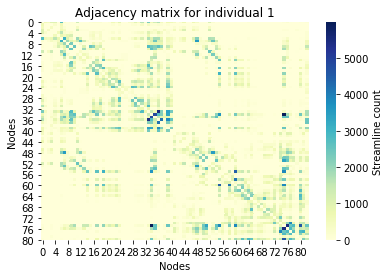

In [3]:
# Load in one brain
example_number = 1    # Pick any number from 0-23

# Load in one scan as brain_example. 
brain_example = sio.loadmat(f'data/brain_{example_number}.mat')

# The brain_example has the adjacency matrix stored as 'adj'
brain_example = brain_example['adj']

# Symmetrize and set diagonal to 0
brain_example = 0.5*(brain_example + np.transpose(brain_example))
np.fill_diagonal(brain_example,0)

# From this brain, we can find the number of nodes, call it n_nodes
brain_example.shape
n_nodes = brain_example.shape[0]

# Look at the adjacency matrix

# With seaborn
fig_0 = sns.heatmap(brain_example, cbar_kws={'label': 'Streamline count'}, cmap="YlGnBu")
fig_0.set(xlabel = 'Nodes', ylabel = 'Nodes', title = f'Adjacency matrix for individual {example_number}');


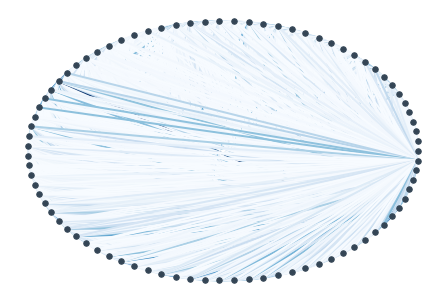

In [4]:
# What does the network itself actually look like?
# Create a weighted graph using networkx

G_example = nx.from_numpy_array(brain_example, parallel_edges = False)
pos = nx.circular_layout(G_example)
colors = [d['weight'] for u,v,d in G_example.edges(data = True)]

nx.draw(G_example, pos, node_color='#344555', edge_color=colors, node_size = 30,
        width=2, edge_cmap=plt.cm.Blues, with_labels=False)
plt.show()

In [5]:
# Yikes that was not so helpful. Let's read in the coordinates of the actual brain data.

coordinates_mat = sio.loadmat('data/LP_coordinates.mat')
x_coord = coordinates_mat['X']
y_coord = coordinates_mat['Y']
z_coord = coordinates_mat['Z']

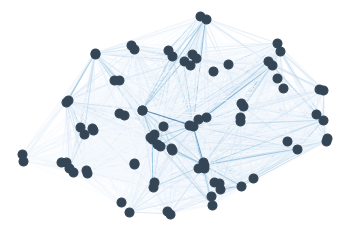

In [6]:
# Now we can plot!

# Need to assign node locations
for node in G_example.nodes():
    G_example.nodes[node]['pos'] = [y_coord[node][0], z_coord[node][0]]
    

pos = nx.get_node_attributes(G_example,'pos')
nx.draw_networkx_edges(G_example,pos,alpha=0.6,edge_color=colors,edge_cmap=plt.cm.Blues)

# Play with different colormaps (https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html). 
# Which colormap is the most helpful?
nx.draw_networkx_nodes(G_example,pos, node_size = 80, node_color = '#344555')
plt.axis('off')
plt.show()

## Interactivity and bokeh

Sometimes you might want the ability to explore your data, or set up your visualization so that others can explore it. This requires not a static plot but an interactive plot in which users can, perhaps, click, drag, zoom, pan, over, or otherwise manipulate the image shown.

Importantly, there are multiple great packages available for interactive plots. In python, the most common are bokeh and plotly. Both are excellent, but we'll stick with just one package today. See (here) for a great plotly tutorial.



In [7]:
# Import packages
import bokeh as bk
from bokeh.palettes import Category20b
from bokeh.palettes import Magma
from bokeh.palettes import Viridis
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
output_notebook()

print(bk.__version__)

Loading BokehJS ...

1.3.4


In [8]:
# Remember the Gaussian distribution? Let's build an interactive plot so that we can better understand the parameters mu and sigma

# Define five values of mu, and five of sigma
mu_values = [-2, -1, 0, 1, 2]
sigma_values = [1, 0.5, 0.4, 0.7, 1.2]

# We'll pick a standard range for x values.
x_axis = np.arange(-5,5,0.01)

# Plot these five Gaussians
p = figure(plot_width=800, plot_height=500)
p.title.text = 'Click on legend entries to hide the corresponding lines'

# Use a for loop to make all five plots
for mu, sigma, color in zip(mu_values, sigma_values, Category20b[5]):
    norm_data = stats.norm.pdf(x_axis, loc = mu, scale = sigma)
    p.line(x_axis, norm_data, line_width=2, color= color, alpha=0.8, legend = f'mu={mu}, sigma={sigma}')

p.legend.location = "top_right"
p.legend.click_policy="hide"
p.xaxis.axis_label = 'X'
p.yaxis.axis_label = 'Probability density'

show(p)

In [9]:
from bokeh.layouts import row, column
from bokeh.models import CustomJS, Slider
from bokeh.plotting import figure, output_file, show, ColumnDataSource

# Note we make a different x axis. Doens't have to be centered at 0.
x = np.linspace(0, 100, 1000)
y = stats.norm.pdf(x, loc = 25, scale = 5)
source = ColumnDataSource(data=dict(x=x, y=y))

# Start figure
plot = figure(y_range=(0, 0.2), plot_width=600, plot_height=400)

# Plot initial line
plot.line('x', 'y', source=source, line_width=3, line_alpha=0.6)

# Define sliders
mu_slider = Slider(start=1, end=100, value=25, step=1, title="Mean")
sigma_slider = Slider(start=1, end=40, value=5, step=1, title="Standard Deviation")

# Javascript lets us make interactive sliders
callback = CustomJS(args=dict(source=source, mu=mu_slider, sigma=sigma_slider),
                    code="""
    const data = source.data;
    const m = mu.value;
    const s = sigma.value;
    const x = data['x']
    const y = data['y']

    for (var i = 0; i < x.length; i++) {
        y[i] = (1/(s*Math.sqrt(2*Math.PI)))*Math.exp(-Math.pow((x[i]-m),2)/(2*Math.pow(s,2)))
    }
    console.log(y)
    source.change.emit();
""")

# Defining what happens when a slider value changes. In this case, the callback function evaluates.
mu_slider.js_on_change('value', callback)
sigma_slider.js_on_change('value', callback)

# Final plot labels and things
plot.xaxis.axis_label = 'X'
plot.yaxis.axis_label = 'Probability Density'
layout = row(
    plot,
    column(mu_slider, sigma_slider),
)


show(layout)